In [1]:
import pandas as pd
from sqlite3 import connect
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import batch_normalization
import tensorflow
from tensorflow_addons.metrics import RSquare
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams


In [2]:
def word_seperator(data, vectorizer, word_list):
    temp_list = [vectorizer.vocabulary_[word] for word in word_list.values]
    return data[:, temp_list]

In [3]:
conn = connect("data/dataset_review.db")
dataset = pd.read_sql("SELECT * FROM games", conn)
conn.close()

dataset.set_index("index", inplace=True)
dataset = dataset.loc[dataset["summary"].notnull()]
dataset = dataset.loc[dataset["reviews"].notnull()]
dataset = dataset[dataset["user_review"] != -1]
dataset.reset_index(drop=True, inplace=True)

In [4]:
# tfv = CountVectorizer(analyzer='word',stop_words = 'english', lowercase=True)
# tfv.fit(dataset["summary"])
# summary = tfv.transform(dataset["summary"]).toarray()

# glove = pd.read_csv('data/glove.840B.300d.txt', sep=" ", header=None)
# glove.set_index(0, inplace=True)
# glove = glove.filter(items=tfv.get_feature_names_out(), axis=0)
# summary = word_seperator(data=summary, vectorizer=tfv, word_list=glove.index)


# kmeans = KMeans(n_clusters=30, random_state=7).fit(pd.DataFrame(summary.dot(glove)))
# del glove

# summary_kmeans = np.array(kmeans.labels_)
# del kmeans
# np.save("data/summary_kmeans.npy", summary_kmeans)

summary_kmeans = np.load("data/summary_kmeans.npy", allow_pickle=True)

In [5]:
categorical_labels = to_categorical(summary_kmeans, num_classes=30)
dataset = pd.concat([dataset, pd.DataFrame(categorical_labels, columns=["summary_kmean_" + str(i) for i in range(30)])], axis=1)
y = dataset["user_review"]
x = dataset.drop(columns=["user_review"])

In [6]:
# count_vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', stop_words = 'english')
# word_vecs = count_vec.fit_transform(dataset["reviews"].values).toarray()
# glove = pd.read_csv('data/glove.840B.300d.txt', sep=" ", header=None)
# glove.set_index(0, inplace=True)
# glove = glove.filter(items=count_vec.get_feature_names_out(), axis=0)
# word_vecs = word_seperator(data=word_vecs, vectorizer=count_vec, word_list=glove.index)

# reviews = word_vecs.dot(glove)
# np.save("data/reviews_glove.npy", reviews)

reviews = np.load("data/reviews_glove.npy", allow_pickle=True)

In [7]:
x.drop(columns=["name", "summary", "reviews"], inplace=True)

x = pd.concat([x, pd.DataFrame(reviews), pd.get_dummies(x.platform, prefix='plat')], axis=1)
x.drop(columns=["platform", "publish_year", "publish_month"], inplace=True)

x = StandardScaler(with_mean=False).fit_transform(x)

svd = decomposition.TruncatedSVD(n_components=200, n_iter=7, random_state=7)
x = svd.fit_transform(x)

E:\Python39\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Python39\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=7, test_size=0.2, shuffle=True)

In [71]:
model = Sequential()

model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())


model.add(Dense(1))
model.add(Activation('relu'))

model.compile(loss="mse", optimizer='adam', metrics=[tensorflow.keras.metrics.RootMeanSquaredError(), RSquare(dtype=tensorflow.float32, y_shape=(1,))])

In [72]:
model_history = model.fit(x_train, y=y_train, batch_size=64, 
          epochs=30, verbose=1, 
          validation_data=(x_valid, y_valid))

Epoch 1/30
186/186 [==============================] - 1s 4ms/step - loss: 0.3111 - root_mean_squared_error: 0.5577 - r_square: -17.4230 - val_loss: 0.1690 - val_root_mean_squared_error: 0.4111 - val_r_square: -8.9272
Epoch 2/30
186/186 [==============================] - 1s 3ms/step - loss: 0.1662 - root_mean_squared_error: 0.4077 - r_square: -8.8424 - val_loss: 0.0984 - val_root_mean_squared_error: 0.3137 - val_r_square: -4.7802
Epoch 3/30
186/186 [==============================] - 1s 3ms/step - loss: 0.1166 - root_mean_squared_error: 0.3414 - r_square: -5.9027 - val_loss: 0.0789 - val_root_mean_squared_error: 0.2809 - val_r_square: -3.6344
Epoch 4/30
186/186 [==============================] - 1s 3ms/step - loss: 0.0925 - root_mean_squared_error: 0.3042 - r_square: -4.4795 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2322 - val_r_square: -2.1684
Epoch 5/30
186/186 [==============================] - 1s 3ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - r_square: -3.1697 

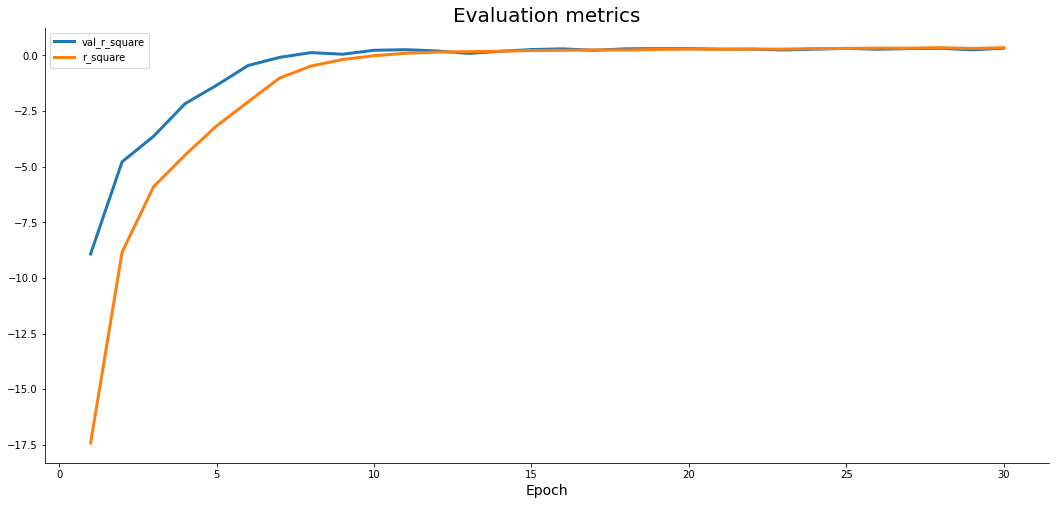

In [73]:
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 31), 
    model_history.history['val_r_square'], 
    label='val_r_square', lw=3
)
plt.plot(
    np.arange(1, 31), 
    model_history.history['r_square'], 
    label='r_square', lw=3
)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

In [77]:
tuple(zip(model.predict(x_valid), y_valid))

((array([0.81752396], dtype=float32), 0.82),
 (array([0.73642886], dtype=float32), 0.8),
 (array([0.72881365], dtype=float32), 0.74),
 (array([0.6261947], dtype=float32), 0.7),
 (array([0.755726], dtype=float32), 0.85),
 (array([0.73014367], dtype=float32), 0.78),
 (array([0.6921501], dtype=float32), 0.75),
 (array([0.7330279], dtype=float32), 0.7),
 (array([0.75117207], dtype=float32), 0.8099999999999999),
 (array([0.6966759], dtype=float32), 0.6599999999999999),
 (array([0.6112019], dtype=float32), 0.64),
 (array([0.6328921], dtype=float32), 0.62),
 (array([0.71177423], dtype=float32), 0.6900000000000001),
 (array([0.76441085], dtype=float32), 0.86),
 (array([0.76810145], dtype=float32), 0.75),
 (array([0.74001336], dtype=float32), 0.8),
 (array([0.809676], dtype=float32), 0.89),
 (array([0.6939147], dtype=float32), 0.67),
 (array([0.6481421], dtype=float32), 0.7),
 (array([0.7443987], dtype=float32), 0.77),
 (array([0.7064682], dtype=float32), 0.41),
 (array([0.7790664], dtype=float